In [26]:
# Install extra dependencies
!pip install -q torchinfo accelerate tqdm

import os
import pandas as pd 
import numpy as np 
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor
from accelerate import Accelerator 
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from IPython.display import clear_output
from tqdm.notebook import tqdm
from time import time

In [27]:
datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")
train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")
training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]

# sanity check, how many images
print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


In [28]:
class CONFIG:
    # use the 16 bit floating point arithmetic (should speeds up training/inference)
    USE_MIXED_PRECISION = None    # other values possible, "fp16" or None

    # downscaling the images : to make the inference on kaggle faster and keep within reason on GPU there, 
    #                          I set it to 2 (so the image is scaled from (256,256) to (128, 128)), None 
    #                          keeps the original shape 
    DOWNSCALE = 4

    # Imagenet channelwise mean
    MEAN = [0.485, 0.456, 0.406]

    # imagenet, channelwise standard deviation
    STD = [0.229, 0.224, 0.225]

    # epsilon for DICE, IoU losses (now 1e-6, however in some papers set to 1)
    EXTRA_LOSS_EPS = 1e-6

    # style of plots, I find darkgrid nice for regular plots
    SNS_STYLE = "darkgrid"

    BATCH_SIZE = 1

    SINGLE_NETWORK_TRAINING_EPOCHS = 15

    CE_VS_DICE_EVAL_EPOCHS = 15

    DELTA_BETA = 0.2

cfg = CONFIG()    

# Create a HuggingFace Accelerate accelerator. This allows using multiple GPUs, TPUs or 
# mixed precision (like brain-float16 or 16bit floating points) which should make training/inference 
# faster
if cfg.USE_MIXED_PRECISION is not None:
    accelerator = Accelerator(mixed_precision=cfg.USE_MIXED_PRECISION)
else:
    accelerator = Accelerator()

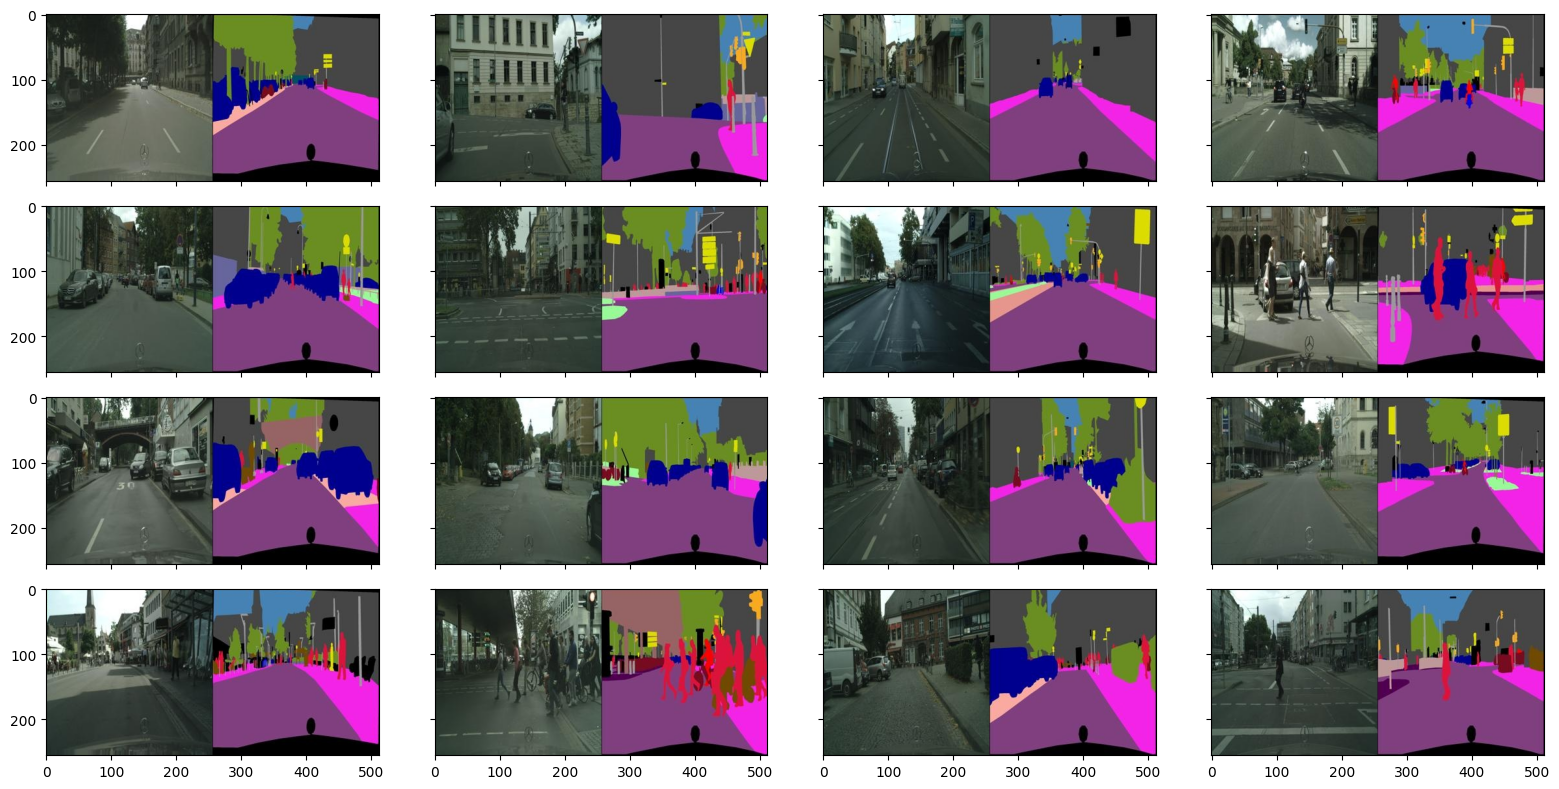

In [29]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]

# create the plot 
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    # read the image
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)
    
    # calculate the indexes for plots and set the image data
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

In [30]:
# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


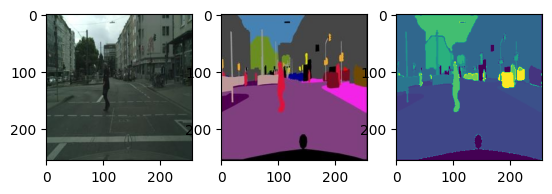

In [31]:
from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

# vectorize the operation of mapping the name to color for numpy (just a lookup in idx_to_color dictionary)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """
    # Read the image from path and dowscale if downscale_factor is not None.
    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel data) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)

    # if we want to operate on names, map the categories to names
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=None)

# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

In [32]:
# train_images_to_use = -1

# # for kaggle
# downscale_factor=cfg.DOWNSCALE

# X_train, Y_train = [], []
# X_val, Y_val = [], []

# for path in tqdm(training_images_paths[:]):
#     X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
#     X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
#     Y_train.append(torch.Tensor(Y))

# for path in tqdm(validation_images_paths):
#     X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
#     X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
#     Y_val.append(torch.Tensor(Y))
    
# # Pytorch Dataset
# class CityScapesDataset(Dataset):
#     def __init__(self, X, Y, transform=None, target_transform=None):
#         self.X = X
#         self.Y = Y
#         self.transform = transform
#         self.target_transform = target_transform
        
#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         x, y = self.X[idx], self.Y[idx]

#         if self.transform:
#             x = self.transform(x)
#         if self.target_transform:
#             y = self.target_transform(y)
#         return x , y
    
    
# # just normalize the data
# preprocess = transforms.Compose([
#     transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
# ])

# # create the Datasets
# train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
# val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# # create the dataloaders
# train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)

In [33]:
# fig, axes = plt.subplots(cfg.BATCH_SIZE, 2, figsize=(4, 2.*cfg.BATCH_SIZE), squeeze=True)
# fig.subplots_adjust(hspace=0.0, wspace=0.0)

# for i in range(cfg.BATCH_SIZE):
#     img, mask = X_train[i], Y_train[i]  
#     #print(img.shape, mask.shape)
#     axes[i, 0].imshow(img.permute(1,2, 0))
#     axes[i,0].set_xticks([])
#     axes[i,0].set_yticks([])
    
#     axes[i, 1].imshow(mask, cmap='magma')
#     axes[i,1].set_xticks([])
#     axes[i,1].set_yticks([])

In [34]:
# eval_batch_data = next(iter(val_dataloader))

# # the images coming from the dataset are now preprocessed : 
# # images are normalized using means and standard deviations coming from ImageNet (x' = (x - \mu) / \std)
# # to decode, multiply by standard deviation, and add mean (x = x' * \std + \mu)

# def decode_image(img : torch.Tensor) -> torch.Tensor:
#     return img * torch.Tensor(cfg.STD) + torch.Tensor(cfg.MEAN)

# print(eval_batch_data[0].shape, eval_batch_data[1].shape)
# batch_size = eval_batch_data[0].shape[0]
# fig, axes = plt.subplots(batch_size, 2, figsize=(4, 2.*batch_size), squeeze=True)
# fig.subplots_adjust(hspace=0.0, wspace=0.0)

# for i in range(batch_size):
#     img, mask = eval_batch_data[0][i], eval_batch_data[1][i]  
#     #print(img.shape, mask.shape)
#     axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
#     axes[i,0].set_xticks([])
#     axes[i,0].set_yticks([])
    
#     axes[i, 1].imshow(mask, cmap='magma')
#     axes[i,1].set_xticks([])
#     axes[i,1].set_yticks([])

In [35]:
# dice loss
# awesome implementation for DICE can be found here
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
def dice_coeff(inp : Tensor, tgt : Tensor, eps=cfg.EXTRA_LOSS_EPS):
    sum_dim = (-1, -2, -3)

    # calculation of intersection   
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # calcaute the dice    
    dice = (inter + eps) / (sets_sum + eps)

    # average the dice of classwise
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = cfg.EXTRA_LOSS_EPS):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

def log_cosh_dice_loss(input: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    # Compute the Dice coefficient
    dice = dice_coeff(input, target)
    
    # Compute Dice loss
    dice_loss_value = 1 - dice
    
    # Apply Log-Cosh to the Dice loss
    return torch.log(torch.cosh(dice_loss_value + eps))

In [36]:
def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False, with_log_cosh_dice_loss=False,blurred=False):
    global epoch_to_fig 
    val_loss = 0
    val_dice = 0
    val_IoU = 0
    val_log_cosh_dice = 0
    number_of_classes=8
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            if blurred == False:
                images, true_masks = batch[0], batch[1]
            if blurred== True:
                _,images, true_masks = batch[0],batch[1], batch[2]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            val_dice += images.shape[0] * (1. - dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            val_IoU += images.shape[0] * (1. - IoU.item())

            if with_log_cosh_dice_loss:
                log_cosh_dice = log_cosh_dice_loss(F.softmax(masks_pred, dim=1).float(),
                                                   F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                loss += log_cosh_dice
                val_log_cosh_dice += images.shape[0] * log_cosh_dice.item()
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(val_IoU / examples_so_far ,3)}, val Dice : {round(val_dice / examples_so_far ,3)}"
            if with_log_cosh_dice_loss:
                descr += f", val Log-Cosh DICE : {round(val_log_cosh_dice / examples_so_far ,3)}"
            pbar.set_description(descr)

    eval_summary = {}
    eval_summary["validation_loss"] = val_loss / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far
    if with_log_cosh_dice_loss:
        eval_summary["validation_log_cosh_DICE_coefficient"] = val_log_cosh_dice / examples_so_far

    return eval_summary

In [37]:
def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch=1,
                with_dice_loss=True, with_IoU_loss=False, with_log_cosh_dice_loss=False):
    global global_step

    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        training_log_cosh_dice = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i, batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1. - dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1. - IoU.item())

                if with_log_cosh_dice_loss:
                    log_cosh_dice = log_cosh_dice_loss(F.softmax(masks_pred, dim=1).float(),
                                                       F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += log_cosh_dice
                    training_log_cosh_dice += images.shape[0] * log_cosh_dice.item()
                
                # Backward and optimize
                accelerator.backward(loss)
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr += f", avg DICE : {round(training_dice / examples_so_far ,3)}"
                    if with_IoU_loss:
                        descr += f", avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    if with_log_cosh_dice_loss:
                        descr += f", avg Log-Cosh DICE : {round(training_log_cosh_dice / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        if with_dice_loss:
            epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        if with_IoU_loss:
            epoch_summary["training_IoU_coefficient"] = training_IoU / examples_so_far
        if with_log_cosh_dice_loss:
            epoch_summary["training_log_cosh_DICE_coefficient"] = training_log_cosh_dice / examples_so_far

        val_summary = evaluate_model(model, val_dataloader, epoch, epochs, criterion, 
                                     with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss, 
                                     with_log_cosh_dice_loss=with_log_cosh_dice_loss)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data

In [38]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]  

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")



In [39]:
def plot_losses_coeffs(training_val_summary):

    if cfg.SNS_STYLE is not None:
        sns.set(style=cfg.SNS_STYLE)

    training = defaultdict(list)
    validation = defaultdict(list)

    m = 0

    for epoch_summary in training_val_summary:
        keys = list(epoch_summary.keys())

        training_keys = [k for k in keys if k.startswith("training")]
        for k in training_keys:
            training[k[len("training")+1:]].append(epoch_summary[k])

        val_keys = [k for k in keys if k.startswith("validation")]
        for k in val_keys:
            validation[k[len("validation")+1:]].append(epoch_summary[k])

    fig, axes = plt.subplots(len(validation.keys()), 1, figsize=(10, 10), sharex=True)

    for i,k in enumerate(validation.keys()):

        if k in training:
            axes[i].plot(training[k], marker='o', linestyle='--', label="training", linewidth=3)


        if validation[k][-1] > validation[k][0]:
            best_idx = np.argmax(validation[k])
        else:
            best_idx = np.argmin(validation[k])
        
        best = validation[k][best_idx]

        axes[i].set_title(f"{k} (validation best : {round(best, 4)})", fontsize=14, fontweight="bold")
        axes[i].plot(validation[k], label="validation", marker='o', linestyle='--', linewidth=3)

        axes[i].plot([0, best_idx], [best, best], linewidth=2, linestyle="--", color='black', alpha=0.5)
        m = max(m, len(validation[k]))
        axes[i].legend()

    axes[-1].set_xticks(list(range(0, m)))
    axes[-1].set_xticklabels(list(range(1, m + 1)))
    sns.set(style="white")

In [40]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 
class UpScale(nn.Module):
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [41]:
# device = "cuda"
# number_of_classes = len(set(name_to_category.values()))
# model = Unet(3, number_of_classes)
# model = model.to(device)

# Unet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
#                                         lr=3e-4, epochs=20, update_pb_every_batch=10,
#                                         with_dice_loss=True, with_IoU_loss=True, with_log_cosh_dice_loss=True)


# clear_output(True)
# plot_losses_coeffs(Unet_training_val_summary)

In [42]:
# batch = next(iter(val_dataloader))
# predictions = model(batch[0].to(device))
# show_inference(batch, predictions)

In [43]:
# torch.save(model,"/kaggle/working/Unet_64x64_0.8539dice.pth")

In [50]:
device = "cuda"

In [88]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image

# Define Gaussian blur function
def gaussian_blur(image, ksize=15):
    return cv2.GaussianBlur(image, (ksize, ksize),0,5)

# Custom Dataset Class
class BlurredDataset(Dataset):
    def __init__(self, dataset, blur_ksize=5):
        self.dataset = dataset
        self.blur_ksize = blur_ksize

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image, true_masks = self.dataset[idx]
        original_image_np = np.array(original_image)  # Convert to numpy array
        blurred_image_np = gaussian_blur(original_image_np, self.blur_ksize)
        noise = 0.1* np.random.randn(*blurred_image_np.shape)
        blurred_image_np += noise
#         noise = 0.1* np.random.randn(*blurred_image_np.shape)
#         blurred_image_np += noise
        blurred_image = torch.tensor(blurred_image_np).float()  # Convert to tensor
        original_image = torch.tensor(original_image_np).float()  # Convert to tensor
        return original_image, blurred_image, true_masks

In [89]:
train_images_to_use = 30 # Control the number of training images used
eval_images_to_use = 1 # Control the number of evaluation images used

# for kaggle
downscale_factor = cfg.DOWNSCALE

X_train, Y_train = [], []
X_val, Y_val = [], []

# Limit the number of images used for training and validation
for path in tqdm(training_images_paths[:train_images_to_use]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths[:eval_images_to_use]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

# PyTorch Dataset
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y

# Normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])

# Create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# Create the DataLoaders
train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)

100%|██████████| 1/1 [00:00<00:00, 106.47it/s]


In [90]:
# Now create the blurred versions of these smaller datasets
blurred_train = BlurredDataset(train_ds)
blurred_test = BlurredDataset(val_ds)

# Create DataLoaders for the smaller blurred datasets
blurred_train_loader = DataLoader(blurred_train, batch_size=1, shuffle=True)
blurred_test_loader = DataLoader(blurred_test, batch_size=1,shuffle=True)

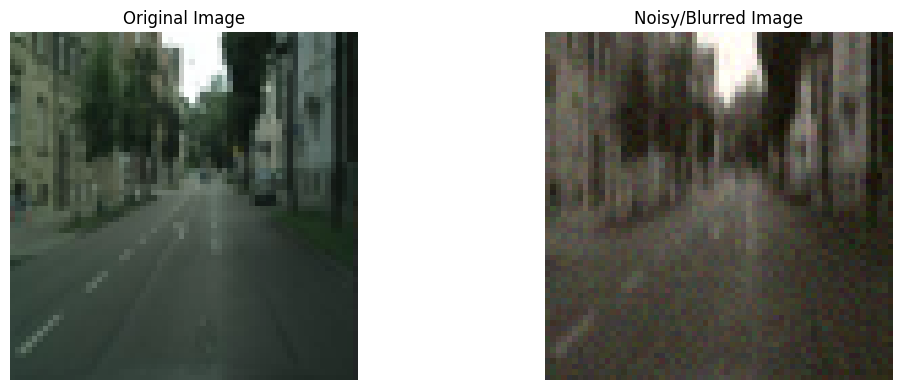

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def plot_original_noisy_label(dataloader, num_samples=1, cmap='gray'):
    """
    Plots a batch of original, noisy (blurred) images, and their corresponding labels (categories).
    
    Args:
        dataloader: The PyTorch dataloader object (should yield original, blurred, and label).
        num_samples: Number of samples to display.
        cmap: Colormap for label visualization (default is 'gray' for category indices).
    """
    # Get a batch of images and labels from the dataloader
    data_iter = iter(dataloader)
    original_images, noisy_images, labels = next(data_iter)

    # Limit the number of images displayed
    num_samples = min(num_samples, original_images.shape[0])

    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

    # Squeeze the axes array if there's only one sample
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # Ensure it's a 2D array for consistency

    for i in range(num_samples):
        # Original image
        original_image = original_images[i].permute(1, 2, 0).cpu().numpy()  # Convert from [C, H, W] to [H, W, C]
        # Noisy (blurred) image
        noisy_image = noisy_images[i].permute(1, 2, 0).cpu().numpy()
        # Ground truth label (classes)
        label_image = labels[i].cpu().numpy()
        
        preprocess = True
        # Normalize image back to [0, 1] range if it was normalized during preprocessing
        if preprocess is not None:
            original_image = (original_image * cfg.STD + cfg.MEAN)
            noisy_image = (noisy_image * cfg.STD + cfg.MEAN)
            original_image = np.clip(original_image, 0, 1)
            noisy_image = np.clip(noisy_image, 0, 1)

        # Plot original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Plot noisy/blurred image
        axes[i, 1].imshow(noisy_image)
        axes[i, 1].set_title("Noisy/Blurred Image")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_original_noisy_label(blurred_train_loader, num_samples=1, cmap='tab20')

In [92]:
T_star = torch.load("/kaggle/input/unet_0.814_val/pytorch/default/3/Unet_64x64_0.8539dice.pth")

/tmp/ipykernel_30/1573391949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  T_star = torch.load("/kaggle/input/unet_0.814_val/pytorch/default/3/Unet_64x64_0.8539dice.pt

In [93]:
# Define the criterion (e.g., cross-entropy)
criterion = torch.nn.CrossEntropyLoss()

# Evaluate on the original dataset
eval_summary = evaluate_model(T_star, val_dataloader, epoch=1, epochs=1, criterion=criterion, with_dice_loss=True, with_IoU_loss=True,blurred=False)
avg_dice = eval_summary["validation_DICE_coefficient"]
avg_iou = eval_summary["validation_IoU_coefficient"]
print(f"Avg Dice on original dataset: {avg_dice:.4f}, Avg mIoU on original dataset: {avg_iou:.4f}")

# Evaluate on the blurred dataset
eval_summary = evaluate_model(T_star, blurred_test_loader, epoch=1, epochs=1, criterion=criterion, with_dice_loss=True, with_IoU_loss=True,blurred= True)
avg_dice = eval_summary["validation_DICE_coefficient"]
avg_iou = eval_summary["validation_IoU_coefficient"]
print(f"Avg Dice on blurred dataset: {avg_dice:.4f}, Avg mIoU on blurred dataset: {avg_iou:.4f}")

Epoch 1/1 ; val Loss 0.411, val IoU : 0.718, val Dice : 0.836: 100%|██████████| 1/1 [00:00<00:00, 107.80it/s]


Avg Dice on original dataset: 0.8357, Avg mIoU on original dataset: 0.7177


Epoch 1/1 ; val Loss 1.261, val IoU : 0.513, val Dice : 0.678: 100%|██████████| 1/1 [00:00<00:00, 123.59it/s]

Avg Dice on blurred dataset: 0.6785, Avg mIoU on blurred dataset: 0.5134


# HOAG # 

In [94]:
def conjugate_gradient(H, b, tol=1e-6, max_iter=100): #used to solve Hx = b, where H is function 
                                                      #that calculates Hx.
    x = torch.zeros_like(b)
    r = b.clone()
    p = r.clone()
    rsold = torch.sum(r*r)

    for i in range(max_iter):
        Hp = H(p)
        alpha = rsold / torch.sum(p* Hp)
        x = x + alpha * p
        r = r - alpha * Hp
        rsnew = torch.sum(r*r)

        if torch.sqrt(rsnew) < tol:
            break

        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

# Smoothed Total Variation Function
def Smoothed_TV(x, theta):
    batch_size = x.size(0)
    diff_x = x[:, :, :, 1:] - x[:, :, :, :-1]
    diff_x = F.pad(diff_x, (0, 1), mode='constant', value=0)
    diff_y = x[:, :, 1:, :] - x[:, :, :-1, :]
    diff_y = F.pad(diff_y, (0, 0, 0, 1), mode='constant', value=0)
    norm_grad = torch.sqrt(diff_x.pow(2) + diff_y.pow(2) + torch.exp(theta[1])**2)
    regularizer = torch.exp(theta[0]) * norm_grad.view(batch_size, -1).mean()
    return regularizer


In [95]:
import torch
import torch.nn.functional as F

def smoothed_norm(x, v):
    return torch.sum(torch.sqrt(x**2 + v**2))

def foe_regularizer(x, theta, kernel_size, num_kernels):
    K = num_kernels
    in_channels = x.size(1)  # Number of input channels (e.g., 3 for RGB)

    # Extract the overall scaling term exp(θ[0])
    exp_theta_0 = torch.exp(theta[0])

    regularizer = 0.0  # Initialize the regularizer
    for k in range(K):
        # Extract the individual kernel for the current filter
        start_idx = 2*K + k * in_channels * kernel_size * kernel_size
        end_idx = start_idx + in_channels * kernel_size * kernel_size
        kernel = theta[start_idx:end_idx].view(in_channels, 1, kernel_size, kernel_size)  # Shape (in_channels, 1, kernel_size, kernel_size)
        
#         print(f"start={start_idx},end:{end_idx},scaling:{k},norm:{K+k}")
        # Perform convolution with single kernel, apply padding
        padding = kernel_size // 2
        conv_x = F.conv2d(x, kernel, padding=padding, groups=in_channels)  # Use groups to apply across channels
#         print(conv_x.shape)
        # Apply smoothed norm
        norm_conv_x = smoothed_norm(conv_x, theta[K + k])  # The scaling term for the k-th kernel

        # Apply individual scaling term exp(θ[K + k + 1])
        exp_theta_k = torch.exp(torch.clamp(theta[k], max=10))  # Avoid overflow

        # Accumulate the regularizer
        regularizer += exp_theta_k * norm_conv_x

    # Apply overall scaling term
    regularizer *= exp_theta_0

    return regularizer

In [96]:
class RegularizerScaler(torch.nn.Module):
    def __init__(self, regu, initial_alpha=10**-5, kernel_size=7, num_kernels=10):
        super(RegularizerScaler, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(initial_alpha))
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        self.regu = regu

    def forward(self, noisy_x, lambda0):
        if self.regu == "smoothed_tv":
            regularizer = Smoothed_TV(noisy_x, lambda0)
        elif self.regu == "FoE":
            regularizer = (10**(-5))*foe_regularizer(noisy_x, lambda0, kernel_size=self.kernel_size, num_kernels=self.num_kernels)
        return regularizer

In [97]:
def inner_loss(noisy_x, x_star, lambda0, regularizer):
    residual = noisy_x - x_star
    loss = torch.mean(residual**2)
    regularizer_term = regularizer.forward(noisy_x, lambda0)
    return loss + regularizer_term

def inner_optimization(noisy_x, lambda0, x_star,regularizer,tol=1e-1, max_iter=100):
    recons_x = noisy_x.requires_grad_(True)
    
    # Include the parameters of the regularizer (i.e., alpha) in the optimizer
    optimizer = optim.LBFGS([recons_x] + list(regularizer.parameters()), lr=1e-1, max_iter=max_iter, tolerance_grad=tol, tolerance_change=tol)

    def closure():
        optimizer.zero_grad()
        loss = inner_loss(noisy_x, x_star,lambda0,regularizer=regularizer).to(noisy_x.device)
        loss.backward(retain_graph= True)
        return loss

    for _ in range(max_iter):
        optimizer.step(closure)

    return recons_x

In [98]:
def compute_Hv(loss, p, u, v, flag="both"): 
    """
    Compute the Hessian-vector product and the gradient.
    
    Parameters:
    - loss: Precomputed scalar loss.
    - p: The vector to multiply with the Hessian.
    - u: Tensor with respect to which the first derivative is taken.
    - v: Tensor with respect to which the Hessian is calculated.
    - flag: Specifies what to return ("grad", "both", "hess").
    
    Returns:
    - Depending on the flag, returns:
      - "grad": Gradient of the loss with respect to u.
      - "both": Gradient of the loss with respect to u and the Hessian-vector product.
      - "hess": Hessian-vector product only.
    """
    grad_u = autograd.grad(loss, u, create_graph=True)[0]
    
    if flag == "grad":
        return grad_u
    
    elif flag == "both":
        dell_u_times_p = torch.sum(grad_u * p)
        Hv = autograd.grad(dell_u_times_p, v, retain_graph=True)[0]
        return grad_u, Hv
    
    elif flag == "hess":
        dell_u_times_p = torch.sum(grad_u * p)
        Hv = autograd.grad(dell_u_times_p, v, retain_graph=True)[0]
        return Hv

def create_H_function(loss, u, v):
    """
    Creates a function H(p) that computes the Hessian-vector product for a given vector p.
    
    Parameters:
    - loss: Precomputed scalar loss.
    - u: Tensor with respect to which the first derivative is taken.
    - v: Tensor with respect to which the Hessian is calculated.
    
    Returns:
    - A function H(p) that computes the Hessian-vector product Hv.
    """
    def H(p):
        return compute_Hv(loss, p, u, v, flag="hess")
    
    return H

In [99]:
def outer_loss_fn(preds, labels, num_classes, with_dice_loss=True, with_IoU_loss=True, with_log_cosh_dice_loss=True):
    criterion = nn.CrossEntropyLoss()
        
    # Cross-entropy loss
    cross_entropy_loss = criterion(preds, labels)

    total_loss = cross_entropy_loss

    # Dice loss
    if with_dice_loss:
        dice = dice_loss(F.softmax(preds, dim=1).float(),
                         F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())
        total_loss += dice

    # IoU loss
    if with_IoU_loss:
        IoU = IoU_loss(F.softmax(preds, dim=1).float(),
                       F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())
        total_loss += IoU

    # Log-cosh dice loss
    if with_log_cosh_dice_loss:
        log_cosh_dice = log_cosh_dice_loss(F.softmax(preds, dim=1).float(),
                                           F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())
        total_loss += log_cosh_dice

    return total_loss

In [100]:
def hoag_algorithm(noisy_x, lambda0, x_star, labels, regu, 
                   T_star, device, outer_loss_fn, max_iter=20, k=1.0, 
                   epsilon=1e-6, kernel_size=5, num_kernels=2):
    
    lambda0 = lambda0.to(device)
    tol = 0.0001  # Initial tolerance

    # Initialize RegularizerScaler
    regularizer = RegularizerScaler(regu=regu, kernel_size=kernel_size, num_kernels=num_kernels).to(device)

    # Step (i): Solve the inner optimization problem to get the initial gradient
    recons_x = inner_optimization(noisy_x, lambda0, x_star, regularizer=regularizer, tol=tol).to(device)
    
    # Compute outer loss using the passed outer_loss_fn function
    output = T_star(recons_x)
    outer_loss = outer_loss_fn(output, labels,8).to(device)
    grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)
    
    # Compute the initial p1 (approximate gradient) and initialize L
    p1 = torch.linalg.matrix_norm(grad_g_x).mean().item()
    L = k * p1

    for iteration in range(max_iter):
        tol = max(tol * (1 - iteration / max_iter)**4, epsilon)  # Ensure tol does not go below epsilon

        # Step (i): Solve the inner optimization problem
        recons_x = inner_optimization(noisy_x, lambda0, x_star, regularizer=regularizer, tol=tol).to(device)
        
        # Compute outer loss using the passed outer_loss_fn function
        output = T_star(recons_x)
        outer_loss = outer_loss_fn(output, labels,8).to(device)
        
        # Compute the gradient with respect to recons_x
        grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)        
        
        # Step (ii): Compute the Hessian-vector product
        new_inner_loss = inner_loss(noisy_x, x_star, lambda0, regularizer).to(device)
        Hxx = create_H_function(new_inner_loss, recons_x, recons_x)
        q_k = conjugate_gradient(Hxx, grad_g_x, tol=tol, max_iter=max_iter)
        hxlambda = compute_Hv(new_inner_loss, q_k, recons_x, lambda0, flag="hess").to(device)
        p_k = -hxlambda
        noisy_x = recons_x

    return p_k, L, outer_loss, regularizer

In [101]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **smoothed_TV**

In [102]:
import time
import copy
import torch
from tqdm import tqdm

# Initialize lambda0
lambda0 = 3 * torch.ones(2, requires_grad=True, device=device)
regu = "smoothed_tv"
saved_images = []


for epoch in range(1):  # Adjust epochs as needed
    # Training Phase
    train_start_time = time.time()
    running_loss = 0.0  # To accumulate the loss

    # Wrap the training loop with tqdm
    train_loader = tqdm(blurred_train_loader, desc=f"Epoch {epoch + 1} Training", leave=False)
    for i, (gt, noisy, labels) in enumerate(train_loader, 1):
        gt_, noisy_, labels_ = gt.to(device), noisy.to(device), labels.long().to(device)
        
        pk, L, loss, regularizer = hoag_algorithm(
            noisy_x=noisy_, lambda0=lambda0, x_star=gt_,
            labels=labels_, regu=regu, outer_loss_fn=outer_loss_fn, 
            T_star=T_star, device=device, max_iter=3, k=1.0,
            epsilon=1e-5, kernel_size=5, num_kernels=2
        )
       
        # Update lambda0
        if L * torch.linalg.vector_norm(pk) < 1:
            lambda0 = lambda0 - L * pk
            lambda0 = lambda0.clamp(min=-2, max=6)

        # Accumulate loss and calculate running average
        running_loss += loss.item()
        avg_loss = running_loss / i  # Calculate running average loss

        # Print iteration details in the progress bar
        train_loader.set_postfix({'lambda0': lambda0.data.cpu().numpy(), 'Avg Loss': avg_loss})
    
    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time
    
    # Calculate and print the final average loss for this epoch
    final_avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} Completed - Final Avg Loss: {final_avg_loss:.4f}, Time Elapsed: {train_elapsed_time:.2f}s")

Epoch 1 Completed - Final Avg Loss: 1.9543, Time Elapsed: 53.17s


In [103]:
# Initialize lists to store outputs for visualization
saved_images = []  # To store reconstructed images, ground truth, and noisy images
saved_masks = []   # To store true segmented masks and predicted masks
num_classes = 8
# Start evaluation
total_dice = 0.0
total_iou = 0.0
total_samples = 0
T_star.eval()

if epoch % 1 == 0:
    eval_start_time = time.time()
    with torch.no_grad():
        # Wrap the evaluation loop with tqdm and calculate running avg dice
        eval_loader = tqdm(blurred_test_loader, desc=f"Epoch {epoch + 1} Evaluation", leave=False)
        for (gt, noisy, labels) in eval_loader:
            gt, noisy, labels = gt.to(device), noisy.to(device), labels.long().to(device)
            noisy_copy = copy.deepcopy(noisy)

            # Solve inner optimization problem
            recons_x = inner_optimization(noisy_x=noisy, lambda0=lambda0, x_star=gt, 
                                           tol=1e-5, regularizer=regularizer, max_iter=50)
            saved_images.append((recons_x.cpu(), gt.cpu(), noisy_copy.cpu()))

            # Predict using T_star
            output = T_star(recons_x)
            preds = output.argmax(dim=1)  # Convert logits to class indices
            
            # Save masks for visualization
            saved_masks.append((labels.cpu(), preds.cpu()))

            # Compute Dice and IoU metrics
            dice_score = 1 - dice_loss(F.softmax(output, dim=1).float(),
                                       F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            iou_score = 1 - IoU_loss(F.softmax(output, dim=1).float(),
                                     F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            total_dice += dice_score.item()
            total_iou += iou_score.item()
            total_samples += labels.size(0)

            # Calculate running averages for Dice
            running_avg_dice = total_dice / total_samples
            running_avg_iou = total_iou / total_samples

            # Update the progress bar
            eval_loader.set_postfix({'Avg Dice': running_avg_dice, 'Avg IoU': running_avg_iou})

    eval_end_time = time.time()
    eval_elapsed_time = eval_end_time - eval_start_time

    # Compute final average metrics
    average_dice = total_dice / total_samples
    average_iou = total_iou / total_samples

    # Print final metrics and time for the epoch
    tqdm.write(f"Epoch {epoch + 1}")
    tqdm.write(f"Training Time: {train_elapsed_time:.2f}s")
    tqdm.write(f"Evaluation Time: {eval_elapsed_time:.2f}s")
    tqdm.write(f"Average Dice: {average_dice:.4f}, Average IoU: {average_iou:.4f}")

Epoch 1
Training Time: 53.17s
Evaluation Time: 0.40s
Average Dice: 0.6788, Average IoU: 0.5138


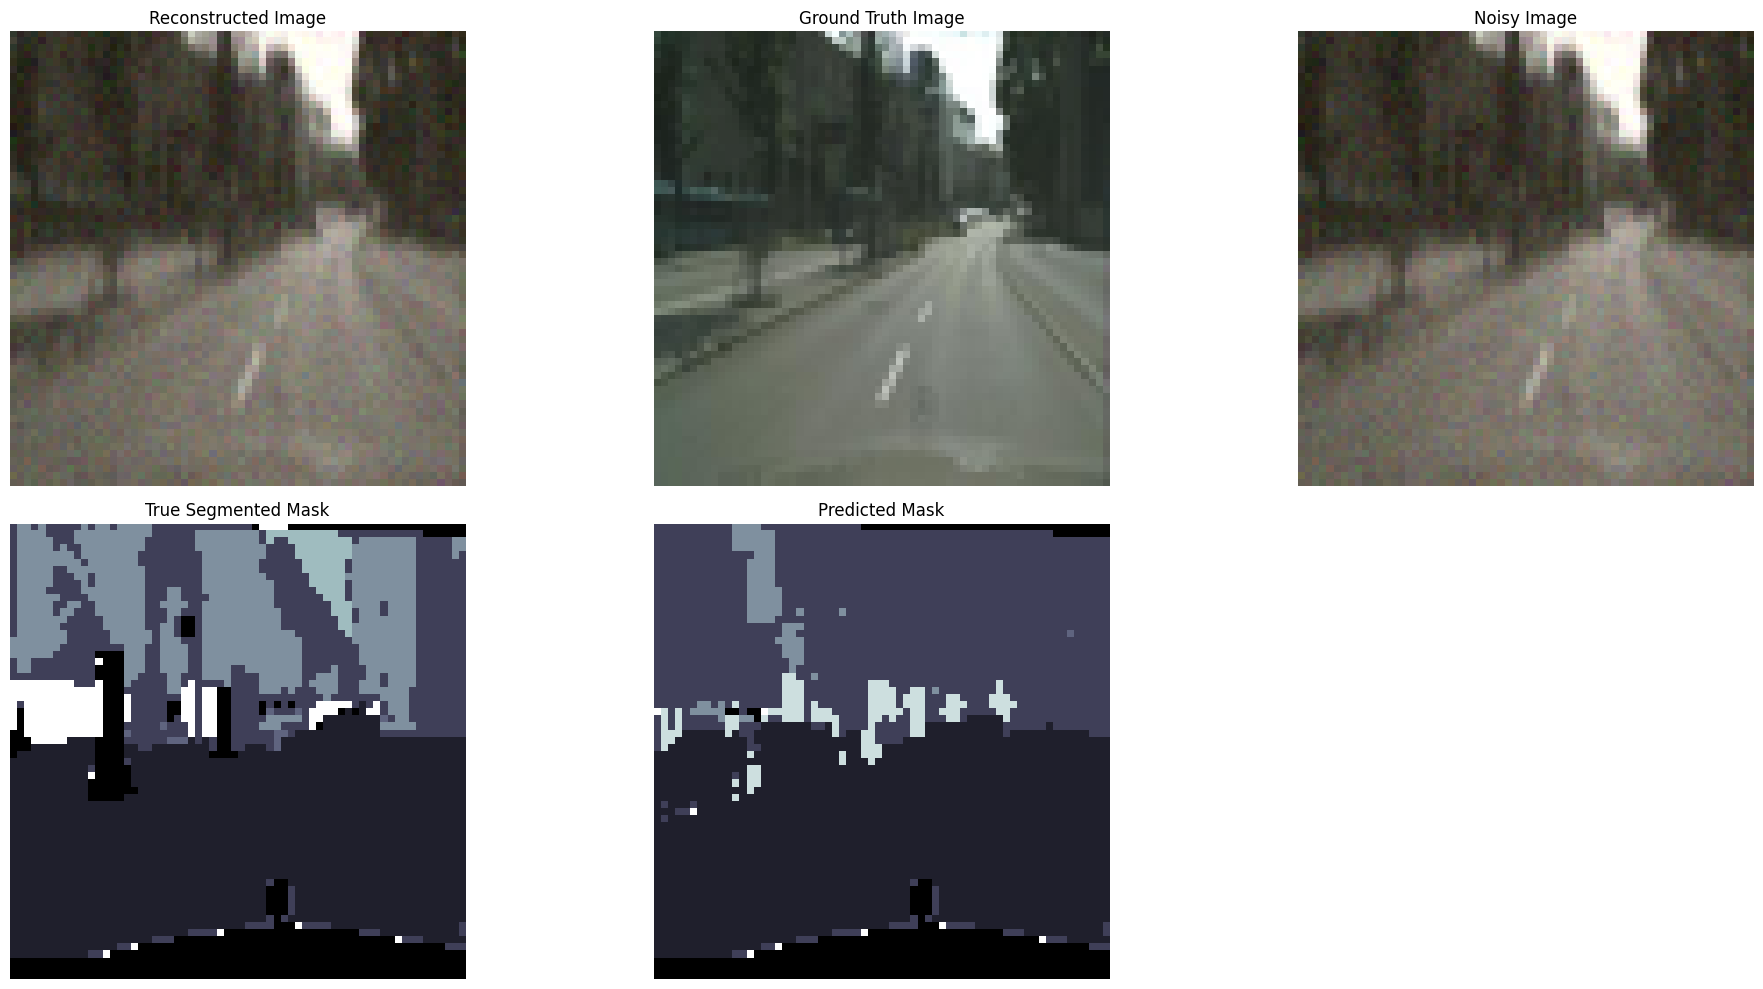

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Function to map class labels to colors for visualization
def map_classes_to_colors(segmentation, num_classes):
    cmap = plt.get_cmap("bone", num_classes)  # Use a colormap suitable for multiple classes
    colored_segmentation = cmap(segmentation.numpy() / (num_classes - 1))  # Normalize classes
    return colored_segmentation[..., :3]  # Drop alpha channel

# Function to denormalize the image
def denormalize(image, mean, std):
    denorm_image = image.clone()  # Clone to avoid modifying original tensor
    for i in range(denorm_image.shape[0]):  # Iterate over channels
        denorm_image[i] = denorm_image[i] * std[i] + mean[i]
    return denorm_image

# Example mean and std used during normalization (replace with your actual values)
mean = cfg.MEAN  # [mean_R, mean_G, mean_B]
std = cfg.STD    # [std_R, std_G, std_B]

# Select an index to plot (change this index to plot different images)
index_to_plot = 0

# Get the saved images and masks from the lists
reconstructed_image, ground_truth, noisy_image = saved_images[index_to_plot]
true_mask, predicted_mask = saved_masks[index_to_plot]

# Select the first image and its corresponding mask
reconstructed_image = reconstructed_image[0]
ground_truth = ground_truth[0]
noisy_image = noisy_image[0]
true_mask = true_mask[0]  # Select first mask
predicted_mask = predicted_mask[0]  # Select first mask

# Denormalize the images
reconstructed_image = denormalize(reconstructed_image, mean, std)
ground_truth = denormalize(ground_truth, mean, std)
noisy_image = denormalize(noisy_image, mean, std)

# Convert tensors to numpy arrays for plotting
reconstructed_image_np = reconstructed_image.permute(1, 2, 0).cpu().numpy()
ground_truth_np = ground_truth.permute(1, 2, 0).cpu().numpy()
noisy_image_np = noisy_image.permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] after denormalization
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
ground_truth_np = np.clip(ground_truth_np, 0, 1)
noisy_image_np = np.clip(noisy_image_np, 0, 1)

# Map labels and predictions to color-coded masks
num_classes = 8  # Adjust this to match the number of classes in your dataset
true_mask_colored = map_classes_to_colors(true_mask.cpu(), num_classes)
predicted_mask_colored = map_classes_to_colors(predicted_mask.cpu(), num_classes)

# Plotting
plt.figure(figsize=(20, 10))

# Row 1: Images
plt.subplot(2, 3, 1)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Ground Truth Image')
plt.imshow(ground_truth_np)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Noisy Image')
plt.imshow(noisy_image_np)
plt.axis('off')

# Row 2: Masks
plt.subplot(2, 3, 4)
plt.title('True Segmented Mask')
plt.imshow(true_mask_colored)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Predicted Mask')
plt.imshow(predicted_mask_colored)
plt.axis('off')

plt.tight_layout()
plt.show()

# **Finetuning Smoothed_TV**

In [ ]:
def hoag_algorithm_with_finetuning(noisy_x, lambda0, x_star, labels, regu, 
                   T_star, device, optimizer, outer_loss_fn,max_iter=20, k=1.0, 
                   epsilon=1e-6,kernel_size= 5,num_kernels=2):
    
    lambda0 = lambda0.to(device)
    tol = 0.0001  # Initial tolerance

    # Initialize RegularizerScaler
    regularizer = RegularizerScaler(regu = regu, kernel_size=kernel_size, num_kernels=num_kernels).to(device)
    # Step (i): Solve the inner optimization problem to get the initial gradient
    recons_x = inner_optimization(noisy_x, lambda0, x_star,regularizer=regularizer, 
                                  tol=tol).to(device)

    for iteration in range(max_iter):

        tol = max(tol * (1 - iteration / max_iter)**5, epsilon)  # Ensure tol does not go below epsilon

        # Step (i): Solve the inner optimization problem
        recons_x = inner_optimization(noisy_x, lambda0, x_star, 
                                      regularizer=regularizer, tol=tol).to(device)
        
        T_star.eval()
        output = T_star(recons_x)
        outer_loss = outer_loss_fn(output, labels,8).to(device)  
        
        # Compute the gradient with respect to recons_x
        grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)        
        
        # Step (ii): Compute the Hessian-vector product
        new_inner_loss = inner_loss(noisy_x, x_star, lambda0, regularizer).to(device)
        Hxx = create_H_function(new_inner_loss, recons_x, recons_x)
        q_k = conjugate_gradient(Hxx, grad_g_x, tol=tol, max_iter=max_iter)
        hxlambda = compute_Hv(new_inner_loss, q_k, recons_x, lambda0, flag="hess").to(device)
        p_k = -hxlambda
        noisy_x = recons_x
    
    T_star.eval()
    output = T_star(recons_x)
    outer_loss = outer_loss_fn(output, labels,8).to(device)    
    grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)
    p1 = torch.linalg.matrix_norm(grad_g_x).mean().item()
    L = k * p1
    
    return p_k, L, outer_loss,regularizer,tol

In [ ]:
# Load the pre-trained U-Net model
T_star_smtv = torch.load("/kaggle/input/unet_0.814_val/pytorch/default/3/Unet_64x64_0.8539dice.pth")

# Freeze all parameters
for param in T_star_smtv.parameters():
    param.requires_grad = False

# Unfreeze specific layers for training (e.g., the last two upsampling layers and the final output layer)
for param in T_star_smtv.up3.parameters():
    param.requires_grad = True

for param in T_star_smtv.up4.parameters():
    param.requires_grad = True

for param in T_star_smtv.outc.parameters():
    param.requires_grad = True

import torch.optim as optim

# Initialize the Adam optimizer for the unfrozen layers
optimizer = optim.Adam(list(T_star_smtv.up3.parameters()) + 
                       list(T_star_smtv.up4.parameters()) + 
                       list(T_star_smtv.outc.parameters()), lr=0.00001)
# optimizer = optim.Adam(T_star_smtv.parameters(), lr=0.0001)

In [ ]:
import time
import copy
import torch
from tqdm import tqdm  # Import tqdm

# Initialize lambda0
lambda0 = 2*torch.ones(2, requires_grad=True, device=device)
regu = "smoothed_tv"

for epoch in range(3):  # Adjust epochs as needed
    # Training Phase
    train_start_time = time.time()
    
    # Initialize variables for loss tracking
    total_outer_loss = 0.0
    batch_count = 0

    # Add tqdm for the training phase
    train_loader = tqdm(blurred_train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)
    for (gt, noisy, labels) in train_loader:
        gt, noisy, labels = gt.to(device), noisy.to(device), labels.long().to(device)
        
        pk, L, loss, regularizer, tol = hoag_algorithm_with_finetuning(
            noisy_x=noisy, lambda0=lambda0, x_star=gt, optimizer=optimizer,
            labels=labels, regu=regu, outer_loss_fn=outer_loss_fn, 
            T_star=T_star_smtv, device=device, max_iter=3, k=1.0,
            epsilon=1e-3, kernel_size=5, num_kernels=2)

        # Update total outer loss
        total_outer_loss += loss.item()
        batch_count += 1

        # Update lambda0
        if L * torch.linalg.vector_norm(pk) < 1:
            lambda0 = lambda0 - L * pk
            lambda0 = lambda0.clamp(min=0, max=6)
        
        # Perform model training
        T_star_smtv.train()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate the average loss so far
        average_loss = total_outer_loss / batch_count if batch_count > 0 else 0.0
        
        # Update tqdm bar with current stats
        train_loader.set_postfix(lambda0=lambda0.data.cpu().numpy(), loss=loss.item(), avg_loss=average_loss, tolerance=tol)

    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time

    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}: Average Loss = {average_loss:.4f}, Time Taken = {train_elapsed_time:.2f}s")

In [ ]:
# Initialize lists to store outputs for visualization
saved_images = []  # To store reconstructed images, ground truth, and noisy images
saved_masks = []   # To store true segmented masks and predicted masks

# Start evaluation
total_dice = 0.0
total_iou = 0.0
total_samples = 0
T_star.eval()

if epoch % 1 == 0:
    eval_start_time = time.time()
    with torch.no_grad():
        # Wrap the evaluation loop with tqdm and calculate running avg dice
        eval_loader = tqdm(blurred_test_loader, desc=f"Epoch {epoch + 1} Evaluation", leave=False)
        for (gt, noisy, labels) in eval_loader:
            gt, noisy, labels = gt.to(device), noisy.to(device), labels.long().to(device)
            noisy_copy = copy.deepcopy(noisy)

            # Solve inner optimization problem
            recons_x = inner_optimization(noisy_x=noisy, lambda0=lambda0, x_star=gt, 
                                           tol=1e-3, regularizer=regularizer, max_iter=50)
            saved_images.append((recons_x.cpu(), gt.cpu(), noisy_copy.cpu()))

            # Predict using T_star
            output = T_star_smtv(recons_x)
            preds = output.argmax(dim=1)  # Convert logits to class indices
            
            # Save masks for visualization
            saved_masks.append((labels.cpu(), preds.cpu()))

            # Compute Dice and IoU metrics
            dice_score = 1 - dice_loss(F.softmax(output, dim=1).float(),
                                       F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            iou_score = 1 - IoU_loss(F.softmax(output, dim=1).float(),
                                     F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            total_dice += dice_score.item()
            total_iou += iou_score.item()
            total_samples += labels.size(0)

            # Calculate running averages for Dice
            running_avg_dice = total_dice / total_samples
            running_avg_iou = total_iou / total_samples

            # Update the progress bar
            eval_loader.set_postfix({'Avg Dice': running_avg_dice, 'Avg IoU': running_avg_iou})

    eval_end_time = time.time()
    eval_elapsed_time = eval_end_time - eval_start_time

    # Compute final average metrics
    average_dice = total_dice / total_samples
    average_iou = total_iou / total_samples

    # Print final metrics and time for the epoch
    tqdm.write(f"Epoch {epoch + 1}")
    tqdm.write(f"Training Time: {train_elapsed_time:.2f}s")
    tqdm.write(f"Evaluation Time: {eval_elapsed_time:.2f}s")
    tqdm.write(f"Average Dice: {average_dice:.4f}, Average IoU: {average_iou:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to map class labels to colors for visualization
def map_classes_to_colors(segmentation, num_classes):
    cmap = plt.get_cmap("bone", num_classes)  # Use a colormap suitable for multiple classes
    colored_segmentation = cmap(segmentation.numpy() / (num_classes - 1))  # Normalize classes
    return colored_segmentation[..., :3]  # Drop alpha channel

# Function to denormalize the image
def denormalize(image, mean, std):
    denorm_image = image.clone()  # Clone to avoid modifying original tensor
    for i in range(denorm_image.shape[0]):  # Iterate over channels
        denorm_image[i] = denorm_image[i] * std[i] + mean[i]
    return denorm_image

# Example mean and std used during normalization (replace with your actual values)
mean = cfg.MEAN  # [mean_R, mean_G, mean_B]
std = cfg.STD    # [std_R, std_G, std_B]

# Select an index to plot (change this index to plot different images)
index_to_plot = 2

# Get the saved images and masks from the lists
reconstructed_image, ground_truth, noisy_image = saved_images[index_to_plot]
true_mask, predicted_mask = saved_masks[index_to_plot]

# Select the first image and its corresponding mask
reconstructed_image = reconstructed_image[0]
ground_truth = ground_truth[0]
noisy_image = noisy_image[0]
true_mask = true_mask[0]  # Select first mask
predicted_mask = predicted_mask[0]  # Select first mask

# Denormalize the images
reconstructed_image = denormalize(reconstructed_image, mean, std)
ground_truth = denormalize(ground_truth, mean, std)
noisy_image = denormalize(noisy_image, mean, std)

# Convert tensors to numpy arrays for plotting
reconstructed_image_np = reconstructed_image.permute(1, 2, 0).cpu().numpy()
ground_truth_np = ground_truth.permute(1, 2, 0).cpu().numpy()
noisy_image_np = noisy_image.permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] after denormalization
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
ground_truth_np = np.clip(ground_truth_np, 0, 1)
noisy_image_np = np.clip(noisy_image_np, 0, 1)

# Map labels and predictions to color-coded masks
num_classes = 8  # Adjust this to match the number of classes in your dataset
true_mask_colored = map_classes_to_colors(true_mask.cpu(), num_classes)
predicted_mask_colored = map_classes_to_colors(predicted_mask.cpu(), num_classes)

# Plotting
plt.figure(figsize=(20, 10))

# Row 1: Images
plt.subplot(2, 3, 1)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Ground Truth Image')
plt.imshow(ground_truth_np)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Noisy Image')
plt.imshow(noisy_image_np)
plt.axis('off')

# Row 2: Masks
plt.subplot(2, 3, 4)
plt.title('True Segmented Mask')
plt.imshow(true_mask_colored)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Predicted Mask')
plt.imshow(predicted_mask_colored)
plt.axis('off')

plt.tight_layout()
plt.show()

# **baseline**

In [ ]:
# Load the pre-trained U-Net model
T_star_smtv = torch.load("/kaggle/input/unet_0.814_val/pytorch/default/3/Unet_64x64_0.8539dice.pth")

# Freeze all parameters
for param in T_star_smtv.parameters():
    param.requires_grad = False

# Unfreeze specific layers for training (e.g., the last two upsampling layers and the final output layer)
for param in T_star_smtv.up3.parameters():
    param.requires_grad = True

for param in T_star_smtv.up4.parameters():
    param.requires_grad = True

for param in T_star_smtv.outc.parameters():
    param.requires_grad = True

import torch.optim as optim

# Initialize the Adam optimizer for the unfrozen layers
optimizer = optim.Adam(list(T_star_smtv.up3.parameters()) + 
                       list(T_star_smtv.up4.parameters()) + 
                       list(T_star_smtv.outc.parameters()), lr=0.00001)
# optimizer = optim.Adam(T_star_smtv.parameters(), lr=0.0001)

In [ ]:
import time
import copy
import torch
from tqdm import tqdm  # Import tqdm

# Initialize lambda0
lambda0 = 2*torch.ones(2, requires_grad=True, device=device)
regu = "smoothed_tv"

for epoch in range(3):  # Adjust epochs as needed
    # Training Phase
    train_start_time = time.time()
    
    # Initialize variables for loss tracking
    total_outer_loss = 0.0
    batch_count = 0

    # Add tqdm for the training phase
    train_loader = tqdm(blurred_train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)
    for (gt, noisy, labels) in train_loader:
        gt, noisy, labels = gt.to(device), noisy.to(device), labels.long().to(device)
        
        pk, L, loss, regularizer, tol = hoag_algorithm_with_finetuning(
            noisy_x=noisy, lambda0=lambda0, x_star=gt, optimizer=optimizer,
            labels=labels, regu=regu, outer_loss_fn=outer_loss_fn, 
            T_star=T_star_smtv, device=device, max_iter=3, k=1.0,
            epsilon=1e-3, kernel_size=5, num_kernels=2)

        # Update total outer loss
        total_outer_loss += loss.item()
        batch_count += 1

        # Update lambda0
#         if L * torch.linalg.vector_norm(pk) < 1:
#             lambda0 = lambda0 - L * pk
#             lambda0 = lambda0.clamp(min=0, max=6)
        
        # Perform model training
        T_star_smtv.train()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate the average loss so far
        average_loss = total_outer_loss / batch_count if batch_count > 0 else 0.0
        
        # Update tqdm bar with current stats
        train_loader.set_postfix(lambda0=lambda0.data.cpu().numpy(), loss=loss.item(), avg_loss=average_loss, tolerance=tol)

    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time

    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}: Average Loss = {average_loss:.4f}, Time Taken = {train_elapsed_time:.2f}s")

In [ ]:
# Initialize lists to store outputs for visualization
saved_images = []  # To store reconstructed images, ground truth, and noisy images
saved_masks = []   # To store true segmented masks and predicted masks

# Start evaluation
total_dice = 0.0
total_iou = 0.0
total_samples = 0
T_star.eval()

if epoch % 1 == 0:
    eval_start_time = time.time()
    with torch.no_grad():
        # Wrap the evaluation loop with tqdm and calculate running avg dice
        eval_loader = tqdm(blurred_test_loader, desc=f"Epoch {epoch + 1} Evaluation", leave=False)
        for (gt, noisy, labels) in eval_loader:
            gt, noisy, labels = gt.to(device), noisy.to(device), labels.long().to(device)
            noisy_copy = copy.deepcopy(noisy)

            # Solve inner optimization problem
            recons_x = inner_optimization(noisy_x=noisy, lambda0=lambda0, x_star=gt, 
                                           tol=1e-3, regularizer=regularizer, max_iter=50)
            saved_images.append((recons_x.cpu(), gt.cpu(), noisy_copy.cpu()))

            # Predict using T_star
            output = T_star_smtv(recons_x)
            preds = output.argmax(dim=1)  # Convert logits to class indices
            
            # Save masks for visualization
            saved_masks.append((labels.cpu(), preds.cpu()))

            # Compute Dice and IoU metrics
            dice_score = 1 - dice_loss(F.softmax(output, dim=1).float(),
                                       F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            iou_score = 1 - IoU_loss(F.softmax(output, dim=1).float(),
                                     F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            total_dice += dice_score.item()
            total_iou += iou_score.item()
            total_samples += labels.size(0)

            # Calculate running averages for Dice
            running_avg_dice = total_dice / total_samples
            running_avg_iou = total_iou / total_samples

            # Update the progress bar
            eval_loader.set_postfix({'Avg Dice': running_avg_dice, 'Avg IoU': running_avg_iou})

    eval_end_time = time.time()
    eval_elapsed_time = eval_end_time - eval_start_time

    # Compute final average metrics
    average_dice = total_dice / total_samples
    average_iou = total_iou / total_samples

    # Print final metrics and time for the epoch
    tqdm.write(f"Epoch {epoch + 1}")
    tqdm.write(f"Training Time: {train_elapsed_time:.2f}s")
    tqdm.write(f"Evaluation Time: {eval_elapsed_time:.2f}s")
    tqdm.write(f"Average Dice: {average_dice:.4f}, Average IoU: {average_iou:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to map class labels to colors for visualization
def map_classes_to_colors(segmentation, num_classes):
    cmap = plt.get_cmap("bone", num_classes)  # Use a colormap suitable for multiple classes
    colored_segmentation = cmap(segmentation.numpy() / (num_classes - 1))  # Normalize classes
    return colored_segmentation[..., :3]  # Drop alpha channel

# Function to denormalize the image
def denormalize(image, mean, std):
    denorm_image = image.clone()  # Clone to avoid modifying original tensor
    for i in range(denorm_image.shape[0]):  # Iterate over channels
        denorm_image[i] = denorm_image[i] * std[i] + mean[i]
    return denorm_image

# Example mean and std used during normalization (replace with your actual values)
mean = cfg.MEAN  # [mean_R, mean_G, mean_B]
std = cfg.STD    # [std_R, std_G, std_B]

# Select an index to plot (change this index to plot different images)
index_to_plot = 2

# Get the saved images and masks from the lists
reconstructed_image, ground_truth, noisy_image = saved_images[index_to_plot]
true_mask, predicted_mask = saved_masks[index_to_plot]

# Select the first image and its corresponding mask
reconstructed_image = reconstructed_image[0]
ground_truth = ground_truth[0]
noisy_image = noisy_image[0]
true_mask = true_mask[0]  # Select first mask
predicted_mask = predicted_mask[0]  # Select first mask

# Denormalize the images
reconstructed_image = denormalize(reconstructed_image, mean, std)
ground_truth = denormalize(ground_truth, mean, std)
noisy_image = denormalize(noisy_image, mean, std)

# Convert tensors to numpy arrays for plotting
reconstructed_image_np = reconstructed_image.permute(1, 2, 0).cpu().numpy()
ground_truth_np = ground_truth.permute(1, 2, 0).cpu().numpy()
noisy_image_np = noisy_image.permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] after denormalization
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
ground_truth_np = np.clip(ground_truth_np, 0, 1)
noisy_image_np = np.clip(noisy_image_np, 0, 1)

# Map labels and predictions to color-coded masks
num_classes = 8  # Adjust this to match the number of classes in your dataset
true_mask_colored = map_classes_to_colors(true_mask.cpu(), num_classes)
predicted_mask_colored = map_classes_to_colors(predicted_mask.cpu(), num_classes)

# Plotting
plt.figure(figsize=(20, 10))

# Row 1: Images
plt.subplot(2, 3, 1)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Ground Truth Image')
plt.imshow(ground_truth_np)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Noisy Image')
plt.imshow(noisy_image_np)
plt.axis('off')

# Row 2: Masks
plt.subplot(2, 3, 4)
plt.title('True Segmented Mask')
plt.imshow(true_mask_colored)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Predicted Mask')
plt.imshow(predicted_mask_colored)
plt.axis('off')

plt.tight_layout()
plt.show()